In [165]:
import io
from itertools import count
import pymysql
import getpass
import pandas as pd

import networkx as nx
from networkx import Graph as NXGraph
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections

from IPython.display import display, Image

from ipywidgets import interact, FloatSlider, IntSlider, interactive, HBox, Checkbox, BoundedIntText

In [53]:
conn = pymysql.connect(host = 'localhost',
                       user = 'root', 
                       passwd = 'qwerty123', 
                       database = 'usa_flights') # só muda aqui para flights / usa_flights

cur = conn.cursor()

Arrumando pequeno detalhe do banco:

In [25]:
query = '''
        UPDATE manufacturer
        SET Name = 'EMBRAER'
        WHERE Name = 'EMBRAER-EMPRESA BRASILEIRA DE' OR Name = 'EMBRAER S A' OR Name = 'EMBRAER-EMPRESA BRASILEIRA DE'
        ;
        '''

cur.execute(query)



query = '''
        UPDATE manufacturer
        SET Name = 'MCDONNELL DOUGLAS'
        WHERE Name = 'MCDONNELL DOUGLAS CORPORATION' OR Name = 'MCDONNELL DOUGLAS AIRCRAFT CO'
        ;
        '''

cur.execute(query)



query = '''
        SELECT *
        FROM manufacturer
        ;
        '''

pd.read_sql_query(query, conn)

OperationalError: (1205, 'Lock wait timeout exceeded; try restarting transaction')

In [ ]:
limite = 12

query = '''
        SELECT C.Company AS Company,
               M.Name AS Manufacturer,
               COUNT(A.N_Number) AS Aircrafts
        FROM (SELECT Companies.name AS Company,
                     Companies.id_company AS ID,
                     COUNT(Aircrafts.N_Number) AS Flights
              FROM Flights
              INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
              INNER JOIN Routes ON Flights.Route_id = Routes.id_route
              INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
              GROUP BY Companies.name
              ORDER BY Flights DESC
              LIMIT {}) AS C
        INNER JOIN aircrafts AS A ON C.ID = A.Companys_id
        INNER JOIN aircraft_models AS AM ON A.Aircraft_Models_id = AM.id_model
        INNER JOIN manufacturer AS M ON AM.Manufacturer_id = M.id_manufacturer
        GROUP BY Company, Manufacturer
        ORDER BY Aircrafts DESC
        ;
        '''.format(limite)

In [19]:
def graph(comp, airp):
    print("Plotando a(s) {} companhia(s) junto do(s) {} aeroporto(s) mais movimentados".format(comp, airp))
    conn = pymysql.connect(host = 'localhost',
                           user = 'root', 
                           passwd = 'qwerty123', 
                           database = 'usa_flights')
    
    G = nx.DiGraph()
    
    # query para pegar as companhias com maior volume de voos e adicionar numa lista (companies)
    # e passar para a lista include strings da forma "Companies.name = ..." as quais serão, no
    # final, incluidas numa string where que fará as restrições da query final
    query = '''
            SELECT Companies.name AS Companny,
                   COUNT(Aircrafts.N_Number) AS Flights
            FROM Flights
            INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
            INNER JOIN Routes ON Flights.Route_id = Routes.id_route
            INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
            GROUP BY Companies.name
            ORDER BY Flights DESC
            ;
            '''
    df = pd.read_sql_query(query, conn)
    include = []
    i = 0
    while i < comp:
#         G.add_node(df.loc[i, 'Companny'], color = 'lightskyblue')
        include.append("Companies.name = '{}'".format(df.loc[i, 'Companny']))
        i += 1
    
    where = ""
    for k in include:
        if k == include[-1]:
            where += k
        else:
            where += k
            where += " OR "
    
    # query para ver os aeroportos com maior volume de voo, em seguida será criado uma lista
    # com airp (variável de entrada que diz quantos aeroportos considerar) aeroportos
    query = '''
            SELECT A.Arrival AS Airport,
                   A.Flights + D.Flights AS Total
            FROM (SELECT Routes.Arrival_Airport_id AS Arrival,
                         COUNT(Aircrafts.N_Number) AS Flights
                  FROM Flights
                  INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
                  INNER JOIN Routes ON Flights.Route_id = Routes.id_route
                  INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
                  WHERE {0}
                  GROUP BY Routes.Arrival_Airport_id
                  ORDER BY RAND()) AS A
            INNER JOIN (SELECT Routes.Departure_Airport_id AS Departure,
                        COUNT(Aircrafts.N_Number) AS Flights
                        FROM Flights
                        INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
                        INNER JOIN Routes ON Flights.Route_id = Routes.id_route
                        INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
                        WHERE {0}
                        GROUP BY Routes.Departure_Airport_id
                        ORDER BY RAND()) AS D
            ON A.Arrival = D.Departure
            ;
            '''.format(where, where)
    
    df = pd.read_sql_query(query, conn)
    airports = []
    i = 0
    while i < airp:
        airports.append(df.loc[i, 'Airport'])
        i += 1
    
    # query final
    query = '''
            SELECT Companies.name AS Companny,
                   Routes.Departure_Airport_id AS Departure,
                   Routes.Arrival_Airport_id AS Arrival,
                   COUNT(Aircrafts.N_Number) AS Flights
            FROM Flights
            INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
            INNER JOIN Routes ON Flights.Route_id = Routes.id_route
            INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
            WHERE {0}
            GROUP BY Companies.name, Routes.Departure_Airport_id, Routes.Arrival_Airport_id
            ORDER BY Flights DESC
            ;
            '''.format(where)
    
    
    
    
    
    # criando o grafo com apenas as companhias vistas e com aeroportos aleatórios (mudam a cada plot)
    df = pd.read_sql_query(query, conn)
    for ind in df.index:
        if df.loc[ind, 'Arrival'] in airports and df.loc[ind, 'Departure'] in airports:
            # qualquer coisa trocar a linha 28 por essa linha abaixo (ai o grafo inclui as companhias utilizadas)
            G.add_node(df.loc[ind, 'Companny'], color = 'lightskyblue')
            G.add_node(df.loc[ind, 'Arrival'], color = 'azure')
            G.add_node(df.loc[ind, 'Departure'], color = 'azure')
            G.add_edge(df.loc[ind, 'Arrival'], df.loc[ind, 'Departure'],
                       weight = df.loc[ind, 'Flights'],
                       color = 'steelblue',
                       relation = 'tem rota para')
            if (df.loc[ind, 'Companny'], df.loc[ind, 'Arrival']) in G.edges():
                G.edges()[(df.loc[ind, 'Companny'], df.loc[ind, 'Arrival'])]['weight'] += df.loc[ind, 'Flights']
            else:
                G.add_edge(df.loc[ind, 'Companny'], df.loc[ind, 'Arrival'],
                           weight = df.loc[ind, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')
            if (df.loc[ind, 'Companny'], df.loc[ind, 'Departure']) in G.edges():
                G.edges()[(df.loc[ind, 'Companny'], df.loc[ind, 'Departure'])]['weight'] += df.loc[ind, 'Flights']
            else:
                G.add_edge(df.loc[ind, 'Companny'], df.loc[ind, 'Departure'],
                           weight = df.loc[ind, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')
    
    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.spring_layout(G, scale=1)
    nx.draw_networkx_edge_labels(G, 
                                 pos, 
                                 edge_labels = nx.get_edge_attributes(G,'relation'),
                                 label_pos = 0.5, 
                                 font_size = 9, 
                                 font_color = 'red', 
                                 font_family = 'sans-serif', 
                                 font_weight = 'normal', 
                                 alpha = 1.0, 
                                 bbox = None, 
                                 ax = ax, 
                                 rotate = True)
    
    nx.draw_networkx(G,
                     pos = pos,
                     ax = ax,
                     node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                     edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],)
    
    plt.show()

# variáveis do interact
comp = IntSlider(min = 1, max = 10, value = 5, description = "Companhias")
airp = IntSlider(min = 1, max = 20, value = 10, description = "Aeroportos")

# execução do grafo
ip = interactive(graph, comp = comp, airp = airp)
print("Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo")
display(HBox(ip.children[0:2]))
print("Para a primeira plotagem faça alguma alteração nas seleções acima.")
display(ip.children[-1])

Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo


Para a primeira plotagem faça alguma alteração nas seleções acima.


Output()

In [158]:
max_companies = 12
max_airports = 30


query = '''
        SELECT Companies.name AS Company,
               COUNT(Aircrafts.N_Number) AS Flights
        FROM Flights
        INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
        INNER JOIN Routes ON Flights.Route_id = Routes.id_route
        INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
        GROUP BY Companies.name
        ORDER BY Flights DESC
        LIMIT {}
        ;
        '''.format(max_companies)
companies = pd.read_sql_query(query, conn)
include = []
for i in range(max_companies):
    include.append("Companies.name = '{}'".format(companies.loc[i, 'Company']))

where_comp = ""
for k in include:
    if k == include[-1]:
        where_comp += k
    else:
        where_comp += k
        where_comp += " OR "

# query para ver os aeroportos com maior volume de voo, em seguida será criado uma lista
# com airp (variável de entrada que diz quantos aeroportos considerar) aeroportos
query = '''
        SELECT A.Arrival AS Airport,
               A.Flights + D.Flights AS Total
        FROM (SELECT Routes.Arrival_Airport_id AS Arrival,
                     COUNT(Aircrafts.N_Number) AS Flights
              FROM Flights
              INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
              INNER JOIN Routes ON Flights.Route_id = Routes.id_route
              INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
              WHERE {0}
              GROUP BY Routes.Arrival_Airport_id
              ORDER BY RAND()) AS A
        INNER JOIN (SELECT Routes.Departure_Airport_id AS Departure,
                    COUNT(Aircrafts.N_Number) AS Flights
                    FROM Flights
                    INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
                    INNER JOIN Routes ON Flights.Route_id = Routes.id_route
                    INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
                    WHERE {1}
                    GROUP BY Routes.Departure_Airport_id
                    ORDER BY RAND()) AS D
        ON A.Arrival = D.Departure
        ORDER BY Total DESC
        LIMIT {2}
        ;
        '''.format(where_comp, where_comp, max_airports)

airports = pd.read_sql_query(query, conn)


airports1 = []
airports2 = []
for i in range(max_airports):
    airports1.append("Routes.Departure_Airport_id = '{}'".format(airports.loc[i, 'Airport']))
    airports2.append("Routes.Arrival_Airport_id = '{}'".format(airports.loc[i, 'Airport']))

where_airp1 = ""
for k in airports1:
    if k == airports1[-1]:
        where_airp1 += k
    else:
        where_airp1 += k
        where_airp1 += " OR "

where_airp2 = ""
for k in airports2:
    if k == airports2[-1]:
        where_airp2 += k
    else:
        where_airp2 += k
        where_airp2 += " OR "



# query final
query = '''
        SELECT Companies.name AS Company,
               Routes.Departure_Airport_id AS Departure,
               Routes.Arrival_Airport_id AS Arrival,
               COUNT(Aircrafts.N_Number) AS Flights
        FROM Flights
        INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
        INNER JOIN Routes ON Flights.Route_id = Routes.id_route
        INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
        WHERE ({0}) AND ({1}) AND ({2})
        GROUP BY Companies.name, Routes.Departure_Airport_id, Routes.Arrival_Airport_id
        ORDER BY Flights DESC
        ;
        '''.format(where_comp, where_airp1, where_airp2)

# criando o grafo com apenas as companhias vistas e com aeroportos aleatórios (mudam a cada plot)
routes = pd.read_sql_query(query, conn)

query = '''
        SELECT C.Company AS Company,
               M.Name AS Manufacturer,
               COUNT(A.N_Number) AS Aircrafts
        FROM (SELECT Companies.name AS Company,
                     Companies.id_company AS ID,
                     COUNT(Aircrafts.N_Number) AS Flights
              FROM Flights
              INNER JOIN Aircrafts ON Aircrafts.n_number = Flights.Aircrafts_id
              INNER JOIN Routes ON Flights.Route_id = Routes.id_route
              INNER JOIN Companies ON Companies.id_company = Aircrafts.Companys_id
              GROUP BY Companies.name
              ORDER BY Flights DESC
              LIMIT {}) AS C
        INNER JOIN aircrafts AS A ON C.ID = A.Companys_id
        INNER JOIN aircraft_models AS AM ON A.Aircraft_Models_id = AM.id_model
        INNER JOIN manufacturer AS M ON AM.Manufacturer_id = M.id_manufacturer
        GROUP BY Company, Manufacturer
        ORDER BY Aircrafts DESC
        ;
        '''.format(max_companies)

manufacturers = pd.read_sql_query(query, conn)

In [159]:
companies

,Company,Flights
0,SOUTHWEST AIRLINES INC,54892
1,WELLS FARGO BANK NA TRUSTEE,46412
2,AMERICAN AIRLINES INC,44474
3,UNITED AIRLINES INC,32749
4,DELTA AIR LINES INC,29371
5,SKY WEST AIRLINES INC,29340
6,WILMINGTON TRUST CO TRUSTEE,11608
7,JETBLUE AIRWAYS CORPORATION,10466
8,MESA AIRLINES INC,9621
9,REPUBLIC AIRWAYS INC,9083


In [160]:
airports

,Airport,Total
0,ATL,27794
1,ORD,25577
2,DFW,25040
3,CLT,21113
4,DEN,20065
5,PHX,17454
6,LAX,17248
7,IAH,15136
8,SFO,14227
9,LGA,12838


In [161]:
routes

,Company,Departure,Arrival,Flights
0,AMERICAN AIRLINES INC,CLT,DFW,231
1,DELTA AIR LINES INC,MCO,ATL,216
2,AMERICAN AIRLINES INC,LGA,BOS,213
3,AMERICAN AIRLINES INC,DFW,CLT,213
4,DELTA AIR LINES INC,ATL,MCO,210
5,AMERICAN AIRLINES INC,BOS,LGA,208
6,UNITED AIRLINES INC,IAH,DEN,201
7,AMERICAN AIRLINES INC,BOS,PHL,199
8,UNITED AIRLINES INC,SFO,EWR,198
9,SOUTHWEST AIRLINES INC,PHX,LAS,195


In [163]:
for fabricante in manufacturers.index:
    if manufacturers.loc[fabricante, 'Manufacturer'] == 'EMBRAER-EMPRESA BRASILEIRA DE' or manufacturers.loc[fabricante, 'Manufacturer'] == 'EMBRAER S A':
        manufacturers.loc[fabricante, 'Manufacturer'] = 'EMBRAER'
    elif manufacturers.loc[fabricante, 'Manufacturer'] == 'MCDONNELL DOUGLAS CORPORATION' or manufacturers.loc[fabricante, 'Manufacturer'] == 'MCDONNELL DOUGLAS AIRCRAFT CO':
        manufacturers.loc[fabricante, 'Manufacturer'] = 'MCDONNELL DOUGLAS'
        
manufacturers

,Company,Manufacturer,Aircrafts
0,SOUTHWEST AIRLINES INC,BOEING,607
1,UNITED AIRLINES INC,BOEING,540
2,DELTA AIR LINES INC,BOEING,426
3,WELLS FARGO BANK NA TRUSTEE,BOEING,311
4,WELLS FARGO BANK NA TRUSTEE,AIRBUS,306
5,SKY WEST AIRLINES INC,BOMBARDIER INC,286
6,AMERICAN AIRLINES INC,BOEING,282
7,AMERICAN AIRLINES INC,AIRBUS,217
8,DELTA AIR LINES INC,AIRBUS,208
9,WILMINGTON TRUST CO TRUSTEE,BOEING,171


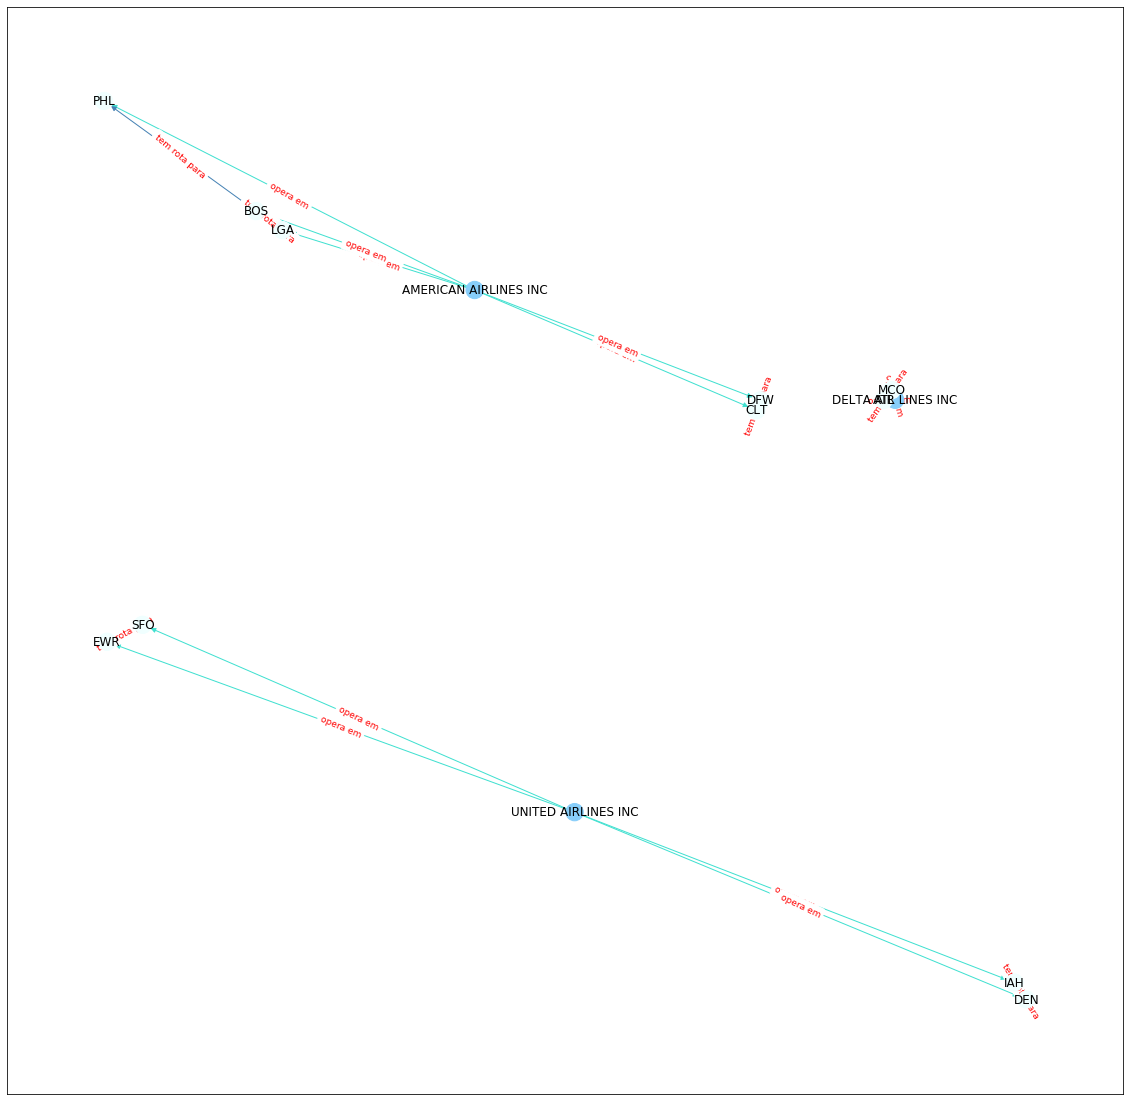

In [143]:
aeroportos = 10
companhias = 5
fabricantes = 0
comp_add = 0
airp_add = 0
fab_add = 0

G = nx.DiGraph()

for companhia in companies.index:
    if comp_add < companhias:
        G.add_node(companies.loc[companhia, 'Company'], color = 'lightskyblue')
        comp_add += 1
        
for fabricante in manufacturers.index:
    if fab_add < fabricantes and manufacturers.loc[fabricante, 'Company'] in G.nodes():
        if manufacturers.loc[fabricante, 'Manufacturer'] not in G.nodes():
            G.add_node(manufacturers.loc[fabricante, 'Manufacturer'], color = 'cadetblue')
            fab_add += 1
        G.add_edge(manufacturers.loc[fabricante, 'Manufacturer'], manufacturers.loc[fabricante, 'Company'],
                   weight = manufacturers.loc[fabricante, 'Aircrafts'],
                   color = 'turquoise',
                   relation = 'fabricou para') 

for rota in routes.index:
    if airp_add < aeroportos and routes.loc[rota, 'Company'] in G.nodes():
        if routes.loc[rota, 'Departure'] not in G.nodes():
            G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
            airp_add += 1
        if routes.loc[rota, 'Arrival'] not in G.nodes():
            G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
            airp_add += 1
        G.add_edge(routes.loc[rota, 'Departure'], routes.loc[rota, 'Arrival'],
                   weight = routes.loc[rota, 'Flights'],
                   color = 'steelblue',
                   relation = 'tem rota para')
        if (routes.loc[rota, 'Company'], routes.loc[rota, 'Departure']) in G.edges():
            G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'])]['weight'] += routes.loc[rota, 'Flights']
        else:
            G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'],
                       weight = routes.loc[rota, 'Flights'],
                       color = 'turquoise',
                       relation = 'opera em')
        if (routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival']) in G.edges():
            G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'])]['weight'] += routes.loc[rota, 'Flights']
        else:
            G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'],
                       weight = routes.loc[rota, 'Flights'],
                       color = 'turquoise',
                       relation = 'opera em')

for companhia in companies.index:
    remove = True
    for u, v in G.edges():
        if u == companies.loc[companhia, 'Company'] or v == companies.loc[companhia, 'Company']:
            remove = False
    if remove:
        try:
            G.remove_node(companies.loc[companhia, 'Company'])
        except:
            pass
            
for fabricante in manufacturers.index:
    remove = True
    for u, v in G.edges():
        if u == manufacturers.loc[fabricante, 'Manufacturer'] or v == manufacturers.loc[fabricante, 'Manufacturer']:
            remove = False
    if remove:
        try:
            G.remove_node(manufacturers.loc[fabricante, 'Manufacturer'])
        except:
            pass

            
            
fig, ax = plt.subplots(figsize=(20,20))
pos = nx.spring_layout(G, scale=1)
nx.draw_networkx_edge_labels(G, 
                             pos, 
                             edge_labels = nx.get_edge_attributes(G,'relation'),
                             label_pos = 0.5, 
                             font_size = 9, 
                             font_color = 'red', 
                             font_family = 'sans-serif', 
                             font_weight = 'normal', 
                             alpha = 1.0, 
                             bbox = None, 
                             ax = ax, 
                             rotate = True)

nx.draw_networkx(G,
                 pos = pos,
                 ax = ax,
                 node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                 edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],)

plt.show()

In [164]:
def graph(n_companies, n_airports, n_manufacturers):
    if n_airports == 0 and n_manufacturers == 0:
        text = '''Plotando a(s) {} maior(es) companhia(s).
        '''.format(n_companies)
    elif n_manufacturers == 0:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} aeroporto(s) mais movimentados.
        '''.format(n_companies, n_airports)
    elif n_airports == 0:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} maior(es) fabricante(s).
        '''.format(n_companies, n_manufacturers)
    else:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} aeroporto(s) mais movimentados e do(s) {} maiores fabricantes
        '''.format(n_companies, n_airports, n_manufacturers)
    
    print(text)
    
    comp_add = 0
    airp_add = 0
    fab_add = 0

    G = nx.DiGraph()
    for rota in routes.index:
        if routes.loc[rota, 'Departure'] not in G.nodes() and routes.loc[rota, 'Arrival'] not in G.nodes() and airp_add <= n_airports - 2:
            G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
            G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
            airp_add += 2
        elif routes.loc[rota, 'Departure'] not in G.nodes() and airp_add < n_airports:
            G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
            airp_add += 1
        elif routes.loc[rota, 'Arrival'] not in G.nodes() and airp_add < n_airports:
            G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
            airp_add += 1

        if routes.loc[rota, 'Company'] not in G.nodes() and comp_add < n_companies:
            G.add_node(routes.loc[rota, 'Company'], color = 'lightskyblue')
            comp_add += 1

        if routes.loc[rota, 'Departure'] in G.nodes() and routes.loc[rota, 'Arrival'] in G.nodes() and routes.loc[rota, 'Company'] in G.nodes():
            if routes.loc[rota, 'Departure'] not in G.nodes():
                G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
                airp_add += 1
            if routes.loc[rota, 'Arrival'] not in G.nodes():
                G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
                airp_add += 1
            G.add_edge(routes.loc[rota, 'Departure'], routes.loc[rota, 'Arrival'],
                       weight = routes.loc[rota, 'Flights'],
                       color = 'steelblue',
                       relation = 'tem rota para')
            if (routes.loc[rota, 'Company'], routes.loc[rota, 'Departure']) in G.edges():
                G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'])]['weight'] += routes.loc[rota, 'Flights']
            else:
                G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'],
                           weight = routes.loc[rota, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')
            if (routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival']) in G.edges():
                G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'])]['weight'] += routes.loc[rota, 'Flights']
            else:
                G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'],
                           weight = routes.loc[rota, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')

    for fabricante in manufacturers.index:
        if fab_add < n_manufacturers and manufacturers.loc[fabricante, 'Company'] in G.nodes():
            if manufacturers.loc[fabricante, 'Manufacturer'] not in G.nodes():
                G.add_node(manufacturers.loc[fabricante, 'Manufacturer'], color = 'cadetblue')
                fab_add += 1
            G.add_edge(manufacturers.loc[fabricante, 'Manufacturer'], manufacturers.loc[fabricante, 'Company'],
                       weight = manufacturers.loc[fabricante, 'Aircrafts'],
                       color = 'turquoise',
                       relation = 'fabricou para')

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.spring_layout(G, scale=1)
    nx.draw_networkx_edge_labels(G, 
                                 pos, 
                                 edge_labels = nx.get_edge_attributes(G,'relation'),
                                 label_pos = 0.5, 
                                 font_size = 9, 
                                 font_color = 'red', 
                                 font_family = 'sans-serif', 
                                 font_weight = 'normal', 
                                 alpha = 1.0, 
                                 bbox = None, 
                                 ax = ax, 
                                 rotate = True)

    nx.draw_networkx(G,
                     pos = pos,
                     ax = ax,
                     node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                     edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],)

    plt.show()

# variáveis do interact
n_companies = IntSlider(min = 1, max = max_companies, value = 5, description = "Companhias")
n_airports = IntSlider(min = 0, max = max_airports, value = 10, description = "Aeroportos")
n_manufacturers = IntSlider(min = 0, max = 5, value = 3, description = "Fabricantes")

# execução do grafo
ip = interactive(graph, n_companies = n_companies, n_airports = n_airports, n_manufacturers = n_manufacturers)
print("Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo")
display(HBox(ip.children[0:3]))
print("Para a primeira plotagem faça alguma alteração nas seleções acima.")
display(ip.children[-1])

Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo


Para a primeira plotagem faça alguma alteração nas seleções acima.


Output()

In [172]:
def graph(n_companies, n_airports, n_manufacturers):
    if n_airports == 0 and n_manufacturers == 0:
        text = '''Plotando a(s) {} maior(es) companhia(s).
        '''.format(n_companies)
    elif n_manufacturers == 0:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} aeroporto(s) mais movimentados.
        '''.format(n_companies, n_airports)
    elif n_airports == 0:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} maior(es) fabricante(s).
        '''.format(n_companies, n_manufacturers)
    else:
        text = '''Plotando a(s) {} companhia(s) junto do(s) {} aeroporto(s) mais movimentados e do(s) {} maiores fabricantes
        '''.format(n_companies, n_airports, n_manufacturers)
    
    print(text)
    
    comp_add = 0
    airp_add = 0
    fab_add = 0

    G = nx.DiGraph()
    for rota in routes.index:
        if routes.loc[rota, 'Departure'] not in G.nodes() and routes.loc[rota, 'Arrival'] not in G.nodes() and airp_add <= n_airports - 2:
            G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
            G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
            airp_add += 2
        elif routes.loc[rota, 'Departure'] not in G.nodes() and airp_add < n_airports:
            G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
            airp_add += 1
        elif routes.loc[rota, 'Arrival'] not in G.nodes() and airp_add < n_airports:
            G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
            airp_add += 1

        if routes.loc[rota, 'Company'] not in G.nodes() and comp_add < n_companies:
            G.add_node(routes.loc[rota, 'Company'], color = 'lightskyblue')
            comp_add += 1

        if routes.loc[rota, 'Departure'] in G.nodes() and routes.loc[rota, 'Arrival'] in G.nodes() and routes.loc[rota, 'Company'] in G.nodes():
            if routes.loc[rota, 'Departure'] not in G.nodes():
                G.add_node(routes.loc[rota, 'Departure'], color = 'azure')
                airp_add += 1
            if routes.loc[rota, 'Arrival'] not in G.nodes():
                G.add_node(routes.loc[rota, 'Arrival'], color = 'azure')
                airp_add += 1
            G.add_edge(routes.loc[rota, 'Departure'], routes.loc[rota, 'Arrival'],
                       weight = routes.loc[rota, 'Flights'],
                       color = 'steelblue',
                       relation = 'tem rota para')
            if (routes.loc[rota, 'Company'], routes.loc[rota, 'Departure']) in G.edges():
                G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'])]['weight'] += routes.loc[rota, 'Flights']
            else:
                G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Departure'],
                           weight = routes.loc[rota, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')
            if (routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival']) in G.edges():
                G.edges()[(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'])]['weight'] += routes.loc[rota, 'Flights']
            else:
                G.add_edge(routes.loc[rota, 'Company'], routes.loc[rota, 'Arrival'],
                           weight = routes.loc[rota, 'Flights'],
                           color = 'turquoise',
                           relation = 'opera em')

    for fabricante in manufacturers.index:
        if fab_add < n_manufacturers and manufacturers.loc[fabricante, 'Company'] in G.nodes():
            if manufacturers.loc[fabricante, 'Manufacturer'] not in G.nodes():
                G.add_node(manufacturers.loc[fabricante, 'Manufacturer'], color = 'cadetblue')
                fab_add += 1
            G.add_edge(manufacturers.loc[fabricante, 'Manufacturer'], manufacturers.loc[fabricante, 'Company'],
                       weight = manufacturers.loc[fabricante, 'Aircrafts'],
                       color = 'turquoise',
                       relation = 'fabricou para')

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.spring_layout(G, scale=1)
    nx.draw_networkx_edge_labels(G, 
                                 pos, 
                                 edge_labels = nx.get_edge_attributes(G,'relation'),
                                 label_pos = 0.5, 
                                 font_size = 9, 
                                 font_color = 'red', 
                                 font_family = 'sans-serif', 
                                 font_weight = 'normal', 
                                 alpha = 1.0, 
                                 bbox = None, 
                                 ax = ax, 
                                 rotate = True)

    nx.draw_networkx(G,
                     pos = pos,
                     ax = ax,
                     node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()],
                     edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],)

    plt.show()

# variáveis do interact

n_companies = BoundedIntText(value = int(max_companies/2), min = 1, max = max_companies, step = 1, description = 'Companhias:', disabled=False)
n_airports = BoundedIntText(value = int(max_airports/2), min = 0, max = max_airports, step = 1, description = 'Aeroportos:', disabled=False)
n_manufactuers = BoundedIntText(value = 3, min = 0, max = 5, step = 1, description = 'Fabricantes:', disabled=False)

# execução do grafo
ip = interactive(graph, n_companies = n_companies, n_airports = n_airports, n_manufacturers = n_manufacturers)
print("Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo")
display(HBox(ip.children[0:3]))
print("Para a primeira plotagem faça alguma alteração nas seleções acima.")
display(ip.children[-1])

Escolha quantas companhias e quantos aeroportos plotar. Essas escolhas são feitas de acordo com o volume de voo


Para a primeira plotagem faça alguma alteração nas seleções acima.


Output()